In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

## Loading images from MNIST Dataset

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype('float32') / 255.0
print("Data-set loaded")

Data-set loaded


## Add Gaussian noise to the images

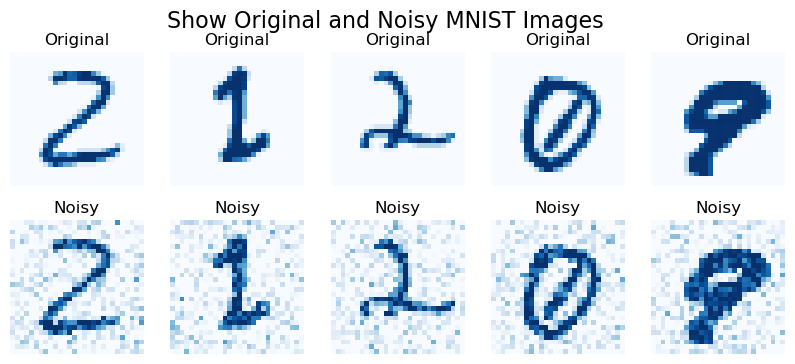

In [9]:
np.random.seed(42)
noise_std_dev = 0.2 
noisy_of_X = X + np.random.normal(0, noise_std_dev, size=X.shape)
noisy_of_X = np.clip(noisy_of_X, 0, 1)  

sample_indi = np.random.choice(len(X), 5, replace=False)
og_samples = X[sample_indi].reshape(-1, 28, 28)
noisy_samples = noisy_of_X[sample_indi].reshape(-1, 28, 28)

plt.figure(figsize=(10, 4))
for i in range(5):
    # Display original images
    plt.subplot(2, 5, i + 1)
    plt.imshow(og_samples[i], cmap='Blues')
    plt.title("Original")
    plt.axis('off')
    
    # Display noisy images
    plt.subplot(2, 5, i + 6)
    plt.imshow(noisy_samples[i], cmap='Blues')
    plt.title("Noisy")
    plt.axis('off')

plt.suptitle('Show Original and Noisy MNIST Images', fontsize=16)
plt.show()

## Reconstruct the denoised image using inverse PCA

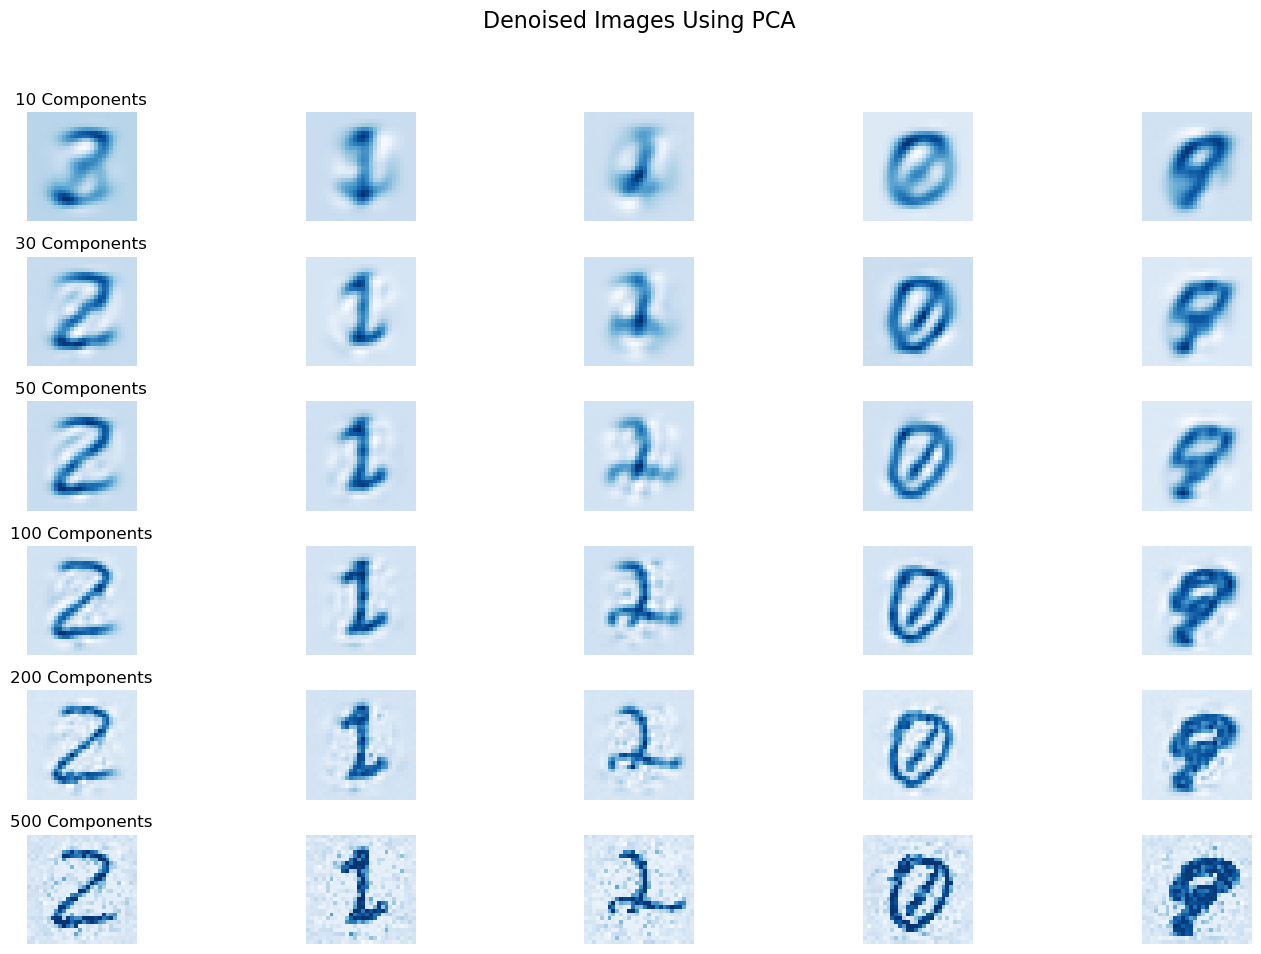

In [12]:
list_of_components = [10, 30, 50, 100, 200, 500]
denoised_samples_list = []

plt.figure(figsize=(15, 10))
for i, components_list in enumerate(list_of_components):
    # Apply PCA on the entire noisy dataset
    pca = PCA(n_components=components_list)
    pca.fit(noisy_X)
    
    # Transform the noisy data to the new principal components space
    reduced_noisy_data = pca.transform(noisy_X)
    
    # Inverse transform to reconstruct the images. This is the denoising step.
    denoised_data = pca.inverse_transform(reduced_noisy_data)
    
    # Store the reconstructed sample images for later display
    denoised_samples = denoised_data[sample_indices].reshape(-1, 28, 28)
    denoised_samples_list.append(denoised_samples)
    
    # Display the denoised images for the current component count
    for j in range(5):
        plt.subplot(len(list_of_components), 5, i * 5 + j + 1)
        plt.imshow(denoised_samples[j], cmap='Blues')
        if j == 0:
            plt.title(f'{components_list} Components')
        plt.axis('off')

plt.suptitle('Denoised Images Using PCA', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Compute the Mean Squared Error (MSE) & Plot the results

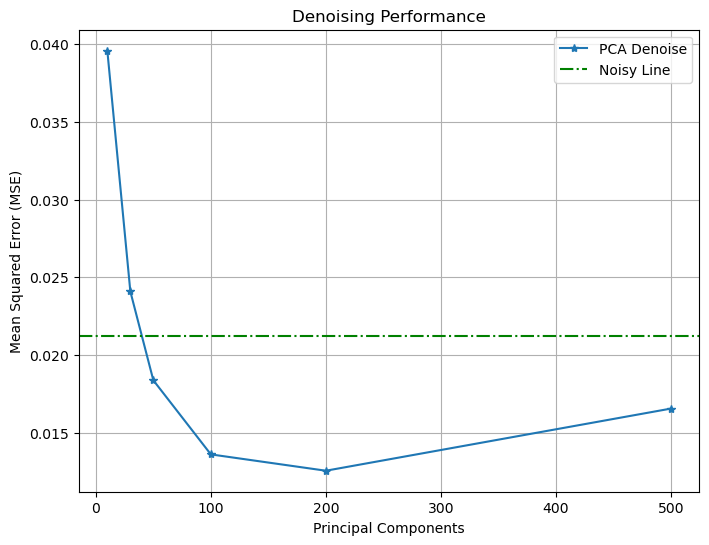

In [22]:
mse_values = []
for components_list in list_of_components:
    pca = PCA(n_components=components_list)
    pca.fit(noisy_of_X)
    denoised_data = pca.inverse_transform(pca.transform(noisy_of_X))
    mse = mean_squared_error(X, denoised_data)
    mse_values.append(mse)

mse_noisy_baseline = mean_squared_error(X, noisy_of_X)

plt.figure(figsize=(8, 6))
plt.plot(list_of_components, mse_values, marker='*', label='PCA Denoise')
plt.axhline(y=mse_noisy_baseline, color='g', linestyle='dashdot', label='Noisy Line')
plt.xlabel('Principal Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Denoising Performance')
plt.legend()
plt.grid(True)
plt.show()

## The core reason PCA is so effective for denoising is that it’s great at telling the difference between a real signal and random noise. The true "signal"—the actual structure of the handwritten digits—has a lot of patterns and consistency. This makes, highly correlated and responsible for most of the data's overall variance. The random noise we added, is disorganized and spread out.

## When PCA analyzes data, it prefers the most variance patterns, which are related to signals. The noise, which is random, does not contribute much to these main patterns and is pushed mainly to one side. By holding only the most important main components, we build a "filter" that reorganizes the image just by using meaningful signal, leaving the random noise.